In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
from gym.envs.registration import registry, register
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt
from minigrid.wrappers import ObservationWrapper

pygame 2.5.2 (SDL 2.28.3, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [16]:
def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


In [17]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class MyDoorKeyEnv(DoorKeyEnv):
    def __init__(self, size):
        self.render_mode = "rgb_array"
        super().__init__(size=size)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]
    
def get_door_key_env(size):
    """
    Returns a DoorKeyEnv environment with the given size.
    """
    env = MyDoorKeyEnv(size=size)
    env = ImgObsWrapper(env)

    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
    #            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
    #            tile_size (int): How many pixels will form a tile from the NxM grid.
    #            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    # show an image to the notebook.
    plt.imshow(frame)

    return env


In [18]:
class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                gae_lambda=0.95,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=True,
                use_gae=True,
                importance_sampling_clip=2.0,
                bad_fit_threshold=0.8,
                bad_fit_increment=None,
                replay_buffer_capacity=10,
                large_buffer_capacity=20):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.use_gae = use_gae # whether to use GAE or not.
        self.importance_sampling_clip = importance_sampling_clip # importance sampling clip threshold
        self.bad_fit_threshold = bad_fit_threshold # threshold for bad fit.
        if bad_fit_increment is None:
            bad_fit_increment = (1.0 - bad_fit_threshold) / replay_buffer_capacity
        self.bad_fit_increment = bad_fit_increment # increment for bad fit.
        self.replay_buffer_capacity = replay_buffer_capacity # capacity of replay buffer.
        self.large_buffer_capacity = large_buffer_capacity # capacity of large replay buffer.
        

In [19]:
class Machine:
    def __init__(self, entropy_coef, init_model:nn.Module, args:Config=None):
        """
        A Machine object consists of a Model and its entropy_coef

        Args:
            entropy_coef: Entropy coefficient.
            init_model: Initial model.
            args
        """
        if args is None:
            self.args = Config()
        else:
            self.args = args

        self.model = init_model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.coef = entropy_coef
        self.device = get_device()

    def copy_model(self, other_model:nn.Module) -> None:
        """
        Copy state dict from 'model'. Reset rs.
        """
        state_dict = other_model.state_dict()
        for key, v in state_dict.items():
            if key in self.model.state_dict():
                self.model.state_dict()[key].copy_(v)

    def copy_machine(self, other:Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        self.copy_model(other.model)

    def _compute_discounted_return(self, rewards):
        """
            rewards: reward obtained at timestep.  Shape: (T,)
            discount: discount factor. float

        ----
        returns: sum of discounted rewards. Shape: (T,)
        """
        returns = torch.zeros(*rewards.shape, device=self.device)

        R = 0
        for t in reversed(range((rewards.shape[0]))):
            R = rewards[t] + self.args.discount * R
            returns[t] = R
        return returns

    def _compute_advantage_gae(self, values, rewards, T):
        """
        Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

        values: value at each timestep (T,)
        rewards: reward obtained at each timestep.  Shape: (T,)
        T: the number of frames, float
        gae_lambda: hyperparameter, float
        discount: discount factor, float

        -----

        returns:

        advantages : tensor.float. Shape [T,]

                    gae advantage term for timesteps 0 to T

        """
        advantages = torch.zeros_like(values)
        for i in reversed(range(T)):
            next_value = values[i+1]
            next_advantage = advantages[i+1]

            delta = rewards[i] + self.args.discount * next_value  - values[i]
            advantages[i] = delta + self.args.discount * self.args.gae_lambda * next_advantage
        return advantages[:T]
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction
            with torch.no_grad():
                dist, value = self.model(obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())

            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)

            total_return += reward
            T += 1

            if done or T >= MAX_FRAMES_PER_EP-1:
                break

        success = (total_return > 0.5)
        
        discounted_reward = self._compute_discounted_return(rewards[:T])
        exps = dict(
            obs = torch.tensor(obss[:T], device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T,
            'success': success
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, dist:Categorical, factors, indices, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0

        coef = self.coef

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        policy_loss_tensor = factors * ppo_loss + coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl
    
    def _compute_value_loss(self, values, returns):
        value_loss = torch.mean((values - returns) ** 2)

        return value_loss

    def update_parameters(self, sb, update_v=True):
        MAX_FRAMES_PER_EP = 300
        T = sb['T']
        with torch.no_grad():
            dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action'])
        init_logp = sb['log_prob']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=get_device())], dim=0)
        full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=get_device())], dim=0)

        if self.args.use_gae:
            advantage = self._compute_advantage_gae(values_extended, full_reward, T)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            dist, values = self.model(sb['obs'])
            values = values.reshape(-1)
            # policy loss
            factors = torch.exp(old_logp - init_logp)
            indices = factors < self.args.importance_sampling_clip
            fit = torch.mean(indices.to(torch.float32))

            loss_pi, approx_kl = self._compute_policy_loss_ppo(dist, factors, indices, old_logp, sb['action'], advantage)
            if update_v:
                loss_v = self._compute_value_loss(values, sb['discounted_reward'])
            else:
                loss_v = 0.0

            if i == 0:
                policy_loss = loss_pi
                value_loss = loss_v

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
            "fit": fit.item()
        }

        return logs
    
    def decrease_prob(self, sb, lr=0.1) -> None:
        self.optim.zero_grad()

        dist, _ = self.model(sb['obs'])
        dist: Categorical
        logps = dist.log_prob(sb['action'])

        loss = lr * torch.mean(logps)
        loss.backward()
        self.optim.step()
    

In [20]:
class PPO:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The PPO agent.
        """

        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True)

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)
    
    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float]]:
        """
        Train the PPO agent.

        Returns:
            num_frames, smooth_rs
        """
        
        print(f'Start! Agent: PPO.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break
            if num_frames >= max_frames:
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs


In [31]:
%matplotlib inline
import pickle
import numpy as np
import random
import gym
import torch
import seaborn as sns
import minigrid
from tqdm.notebook import tqdm
from dataclasses import dataclass

from torch import nn
import pandas as pd
from torch import optim
from typing import Any
from copy import deepcopy
from collections import deque
from minigrid.wrappers import ObservationWrapper
from minigrid.envs.doorkey import DoorKeyEnv

class DQNetwork(nn.Module):
    def __init__(self, action_dim):
        """
        Initializes the DQNetwork with a convolutional neural network architecture.

        Parameters:
        - action_dim (int): The number of possible actions, determining the output size of the network.
        """
        super().__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU()
        )
        self.fcs = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, ob):
        """
        Processes an observation through the network to predict Q values for each action.

        Parameters:
        - ob (torch.Tensor): The input observation image of shape [batch_size, height, width, channels].

        Returns:
        - torch.Tensor: The predicted Q values for each action, of shape [batch_size, action_dim].
        """
        #### TODO (5pts): get the Q values for each action given the input
        #### the input shape is: [batch_size, H, W, 3]
        #### output shape should be: [batch_size, # of actions]
        ob = ob.permute(0, 3, 1, 2)
        bs = ob.size(0)
        out = self.conv_net(ob)
        out = out.view(bs, -1)
        out = self.fcs(out)

        return out

# create a replay buffer
class CyclicBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.cur_pos = 0

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, item):
        return self.buffer[item]

    def append(self, data):
        """
        Adds a new piece of data to the buffer.

        Parameters:
        - data: The data to be added to the buffer.
        """
        #### TODO (10pts): add data to the buffer
        #### if the buffer is not full yet, you can simply append the data to the buffer
        #### otherwise, you need to replace the oldest data with the current data (FIFO)
        #### Hint: you may find self.cur_pos useful, it can be used as a position index
        #### to keep track of where to add data
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
            self.cur_pos = (self.cur_pos + 1) % self.capacity
        else:
            self.buffer[self.cur_pos] = data
            self.cur_pos = (self.cur_pos + 1) % self.capacity

    def sample(self, batch_size):
        """
        Randomly selects a batch of data from the buffer. The size of the batch is the minimum of the requested
        batch size and the current size of the buffer. If the requested batch size equals the buffer size, all
        data in the buffer is returned.

        Parameters:
        - batch_size (int): The size of the batch to sample.

        Returns:
        - list: A list containing the sampled batch of data.
        """
        #### TODO (10pts): sample a batch from the buffer
        bs = min(batch_size, len(self.buffer))
        return random.sample(self.buffer, bs)

    def get_all(self):
        """
        Retrieves all data stored in the buffer.

        Returns:
        - list: A deepcopy of all data currently stored in the buffer.
        """
        return deepcopy(self.buffer)

    def clear(self):
        """
        Removes all data from the buffer, effectively resetting its state.
        """
        self.buffer.clear()
        self.cur_pos = 0

@dataclass
class DQNAgent:
    env: gym.Env
    learning_rate: float
    gamma: float
    memory_size: int # We use memory/buffer interchangeably
    initial_epsilon: float
    min_epsilon: float
    max_epsilon_decay_steps: int
    warmup_steps: int
    batch_size: int
    target_update_freq: int
    enable_double_q: bool = False
    disable_target_net: bool = False
    device: str = None
    tau: float = 0.005

    def __post_init__(self):
        self.reset()

    def reset(self):
        """
        Resets the agent to its initial state.
        """
        if self.device is None:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        #### TODO: create a Deep Q network Agent.
        #### For our purposes include the following:
        #### -a replay buffer with capacity=self.memory_size. Memory = Buffer
        self.memory = CyclicBuffer(self.memory_size)
        #### -an Adam optimizer with lr=self.learning_rate,
        self.qnet = DQNetwork(action_dim=7).to(self.device)
        self.optim = torch.optim.Adam(self.qnet.parameters(), lr=self.learning_rate)
        #### -SmoothL1 loss instance,
        self.loss = nn.SmoothL1Loss()
        ####  -a deep Q network
        ####  -A deep Q TARGET network (Make sure to set to eval mode)
        self.target_qnet = DQNetwork(action_dim=7).to(self.device)
        self.target_qnet.eval()
        #### -Make sure the networks are on the correct device!!! use [tensor].to(self.device)

        ####
        self.epsilon = self.initial_epsilon
        self.ep_reduction = (self.epsilon - self.min_epsilon) / float(self.max_epsilon_decay_steps)
        if self.disable_target_net:
            #### TODO: set the target_update_freq to be proper value so that the target Q network will always be same as the Q network
            #### You don't need to fill in this value until Q4.3
            self.target_update_freq = 1


    @torch.no_grad()
    def get_action(self, ob, greedy_only=False):
        """
        Selects an action based on the current state observation using an epsilon-greedy policy.

        Parameters:
        - ob (numpy.ndarray): The current state observation.
        - greedy_only (bool): If True, the method always selects the action with the highest Q value. If False, it
        selects a random action with probability epsilon.

        Returns:
        - int: The selected action.
        """
        ob = ob[np.newaxis, :]
        ob = torch.from_numpy(ob).float().to(self.device)
        q_val = self.qnet(ob)
        action = self.epsilon_greedy_policy(q_val, greedy_only=greedy_only)
        return action

    def epsilon_greedy_policy(self, q_values, greedy_only=False):
        """
        Implements an epsilon-greedy policy for action selection.

        Parameters:
        - q_values (torch.Tensor): The Q values for all actions in the current state.
        - greedy_only (bool): If True, ignores epsilon and selects the action with the highest Q value.

        Returns:
        - int: The index of the selected action.
        """
        #### TODO: epsilon greedy exploration
        #### we have an extra flag `greedy_only` here,
        #### if greedy_only is True, then we need to return the action that
        #### has the maximum Q values.
        #### if greedy_only is False, we do epsilon greedy.
        mode = 'random'
        if greedy_only:
            mode = 'greedy'
        else:
            if random.random() < self.epsilon:
                mode = 'random'
            else:
                mode = 'greedy'

        if mode == 'random':
            action = np.random.randint(0, 7)
        elif mode == 'greedy':
            action = torch.argmax(q_values).item()
        else:
            raise ValueError('Unknown mode')

        return action

    def add_to_memory(self, ob, next_ob, action, reward, done):
        """
        Adds an experience tuple to the replay buffer.

        Parameters:
        - ob: The current state observation.
        - next_ob: The next state observation after taking the action.
        - action: The action taken in the current state.
        - reward: The reward received after taking the action.
        - done: A boolean indicating whether the episode has ended.
        """
        #### TODO: add data to the replay buffer. Avoid np.arrays.
        data = (ob, next_ob, action, reward, done)
        self.memory.append(data)

    def update_Q(self):
        """
        Performs a single update step of the Q-network based on a batch of experiences from the replay buffer.

        Returns:
        - float: The loss value of the update step.
        """
        # we only start updating the Q network if there are enough samples in the replay buffer
        if len(self.memory) < self.warmup_steps:
            return 0

        #### TODO: sample data from the replay buffer, and put them on the correct device (use [tensor].to(self.device))
        #### you need to make sure the variables are in the right tensor shape.
        data = self.memory.sample(self.batch_size)


        #### TODO: update Q function with Bellman backup. Torch.gather() may prove useful for this section
        ##### get Q(s_t, a_t)
        obs, next_obs, actions, rewards, dones = zip(*data)
        obs = np.array(obs)
        next_obs = np.array(next_obs)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        obs = torch.tensor(obs, device=self.device, dtype=torch.float32)
        next_obs = torch.tensor(next_obs, device=self.device, dtype=torch.float32)
        actions = torch.tensor(actions, device=self.device)
        rewards = torch.tensor(rewards, device=self.device, dtype=torch.float32)
        dones = torch.tensor(dones, device=self.device, dtype=torch.int32)

        q_values = self.qnet(obs)
        # then select the index from q_values according to actions
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)


        ##### get maxQ(s_{t+1}, a_{t+1})
        ##### you will need to implement both DQN and double DQN here
        ##### i.e., you need to check `if self.enable_double_q`
        ##### remember to not propogate gradient when working with target
        if self.enable_double_q:
            with torch.no_grad():
                out = self.qnet(next_obs)
                max_q_indices = torch.max(out, dim=1)[1]

                out = self.target_qnet(next_obs)
                max_q_values = out.gather(1, max_q_indices.unsqueeze(1)).squeeze(1)
        else:
            with torch.no_grad():
                out = self.target_qnet(next_obs)
                max_q_values = torch.max(out, dim=1)[0]


        ##### get the target Q value from the bellman equation
        target_q_values = rewards + (1 - dones) * self.gamma * max_q_values

        ##### update the Q network
        self.optim.zero_grad()
        loss = self.loss(target_q_values, q_values)
        loss.backward()
        self.optim.step()

        return loss.item()

    def decay_epsilon(self):
        """
        Reduces epsilon linearly over time until it reaches min_epsilon, ensuring that the exploration rate decreases
        as the agent learns more about the environment.
        """
        #### TODO: linearly decay epsilon
        #### reduce epsilon value by ep_reduction every time the function is called,
        #### make sure epsilon is not smaller than self.min_epsilon
        self.epsilon = max(self.epsilon - self.ep_reduction, self.min_epsilon)

    def set_epsilon(self, eps) -> None:
        """
        Sets the epsilon value to a specified value.

        Parameters:
        - eps (float): The new epsilon value.
        """
        self.epsilon = eps

    def update_target_qnet(self, step, soft=True):
        """
        Updates the target Q-network.

        Parameters:
        - step (int): The current step number, used to determine when to perform hard updates.
        - soft (bool): If True, performs a soft update; otherwise, performs a hard update.
        """
        if not soft:
            if step % self.target_update_freq == 0:
                #### TODO: update the target Q function in a "hard" way
                #### copy the parameter values in self.qnet into self.target_qnet
                ### use .copy_() to avoid pointer issues
                state_dict = self.qnet.state_dict()
                for key, v in state_dict.items():
                    self.target_qnet.state_dict()[key].copy_(v)
                self.target_qnet.eval()
        else:
            #### TODO: soft update on taget Q network.
            #### similar to polyak averaging, we update the target Q network slowly
            #### $\theta_Qtgt = \tau*\theta_Qtgt + (1-\tau)*\theta_Q
            ###  use .copy_() to avoid pointer issues
            state_dict = self.qnet.state_dict()
            for key, v in state_dict.items():
                self.target_qnet.state_dict()[key].copy_((1 - self.tau) * self.target_qnet.state_dict()[key] + self.tau * v)
            self.target_qnet.eval()

# you don't need to modify the following code.
@dataclass
class DQNEngine:
    env: gym.Env
    agent: DQNAgent
    max_steps: int
    show_progress: bool = False
    show_video: bool = False

    def test(self, env=None, render=False):
        """
        Evaluates the agent's performance in the given environment.

        Parameters:
        - env (gym.Env, optional): The environment to test the agent in. If None, uses the engine's environment.
        - render (bool): Whether to render the environment at each step.

        Returns:
        - float: The total reward accumulated over the episode.
        """
        env = self.env if env is None else env
        ob = env.reset()
        ret = 0
        for i in range(100):
            if render:
                env.render()
            action = self.agent.get_action(ob, greedy_only=True)
            next_ob, reward, done, truncated, info = env.step(action)
            ret += reward
            ob = next_ob
            if done:
                break
        return ret

    def run(self, n_runs=1):
        """
        Executes multiple runs of the agent in the environment, training the agent in each run.

        Parameters:
        - n_runs (int): The number of separate runs to execute.

        Returns:
        - list: A list of pandas DataFrame logs for each run, containing columns for the cumulative reward ('return'),
                the step count ('steps'), the episode number ('episode'), and the initial epsilon value ('epsilon').
        """
        eps = 0.999

        rewards = []
        log = []

        for i in tqdm(range(n_runs), desc='Runs'):
            ep_rewards = []
            ep_steps = []
            self.agent.reset()
            # we plot the smoothed return values
            smooth_ep_return = deque(maxlen=10)
            ob = self.env.reset()
            ret = 0
            num_ep = 0
            for t in tqdm(range(self.max_steps), desc='Step'):
                if len(self.agent.memory) < self.agent.warmup_steps:
                    action = self.env.action_space.sample()
                else:
                    action = self.agent.get_action(ob)
                next_ob, reward, done, truncated, info = self.env.step(action)
                true_done = done and not info.get('TimeLimit.truncated', False)
                self.agent.add_to_memory(ob, next_ob, action, reward, true_done)
                self.agent.update_Q()
                ret += reward
                ob = next_ob
                if done or truncated:
                    ob = self.env.reset()
                    smooth_ep_return.append(ret)
                    ep_rewards.append(np.mean(smooth_ep_return))
                    ep_steps.append(t)
                    ret = 0
                    num_ep += 1
                    if self.show_progress:
                        print(f'Step:{t}  epsilon:{self.agent.epsilon}  '
                            f'Smoothed Training Return:{np.mean(smooth_ep_return)}')
                    if num_ep % 10 == 0:
                        test_ret = self.test()
                        if self.show_progress:
                            print('==========================')
                            print(f'Step:{t} Testing Return: {test_ret}')
                    
                self.agent.decay_epsilon()
                self.agent.update_target_qnet(t, soft=not self.agent.disable_target_net)

            rewards.append(ep_rewards)
            run_log = pd.DataFrame({'return': ep_rewards,
                                    'steps': ep_steps,
                                    'episode': np.arange(len(ep_rewards)),
                                    'epsilon': self.agent.initial_epsilon})
            log.append(run_log)
        return log

def dqn_sweep(agents, labels, n_runs=1, max_steps=100000, show_progress=False):
    """
    Performs a sweep over different DQN agents to compare their performance.
    This function takes a list of DQN agents and their labels, then runs each agent for a specified number of runs and
    steps, tracking their performance. Useful for comparing the effects of different hyperparameters or architectures
    across multiple agents.

    Parameters:
    - agents (list): A list of DQNAgent instances to be evaluated.
    - labels (list): A list of strings representing labels for each agent, used in the logs to identify the agents.
    - n_runs (int): The number of runs to execute for each agent.
    - max_steps (int): The maximum number of steps to execute in each run.
    - show_progress (bool): Whether to display progress bars during execution.

    Returns:
    - pandas.DataFrame: A concatenated DataFrame containing the logs of all runs for all agents, with an additional
                         'Agent' column indicating the label of the agent for each log entry.
    """
    logs = dict()
    for idx, agent in enumerate(tqdm(agents)):
        engine = DQNEngine(env=agent.env, agent=agent,
                           max_steps=max_steps, show_progress=show_progress)
        ep_log = engine.run(n_runs)
        ep_log = pd.concat(ep_log, ignore_index=True)
        ep_log['Agent'] = labels[idx]
        logs[f'{idx}'] = ep_log
    logs = pd.concat(logs, ignore_index=True)
    return logs

def get_default_config():
    config = dict(
        learning_rate=0.00025,
        gamma=0.99,
        memory_size=200000,
        initial_epsilon=1.0,
        min_epsilon=0.1,
        max_epsilon_decay_steps=150000,
        warmup_steps=500,
        target_update_freq=2000,
        batch_size=32,
        device=None,
        disable_target_net=False,
        enable_double_q=True
    )
    return config


In [21]:
class RRR:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        """
        The RRR agent.
        """

        self.env = env

        set_random_seed(seed)
        m1 = ACModelClass(use_critic=True)

        if args is None:
            args = Config()

        self.exploiter = Machine(0.01, m1, args)

        m2 = ACModelClass(use_critic=False)
        m3 = ACModelClass(use_critic=False)
        m4 = ACModelClass(use_critic=False)

        self.explorer_random = Machine(0.03, m2, args)
        self.explorer_thirsty = Machine(0.02, m3, args)
        self.explorer_thirsty.copy_machine(self.exploiter)

        self.temp_machine = Machine(0.01, m3, args)
        self.explorer_bengbuzhu = Machine(0.5, m4, args)

    def _replay(self, machine:Machine, buffer:list, cutoff:float) -> float:
        """
        Replay random sample from buffer on machine.

        Args:
            machine: Machine to replay on
            buffer: list of experiences
            cutoff: if fit < cutoff, delete sb from buffer

        Returns:
            fit
        """

        idx = np.random.randint(len(buffer))
        sb = buffer[idx]
        logs_replay = machine.update_parameters(sb)
        fit = logs_replay['fit']
        if fit < cutoff:
            # delete sb from buffer
            buffer.pop(idx)
        
        return fit
    
    def _add_sb_to_buffer(self, exps, buffer:list, capacity:int) -> None:
        buffer.append(exps)
        if len(buffer) > capacity:
            buffer.pop(0)


    def train(self, max_episodes:int=10000, nonstop:bool=False, max_frames=float('inf')) -> tuple[list[int], list[float], list[float]]:
        """
        Train the agent.

        Returns:
            num_frames, smooth_rs, fits
        """

        print('Start! Agent: RRR.')
        RANDOM_MODE = 0
        EXPLORE_MODE = 1
        EXPLOIT_MODE = 2
        mode = RANDOM_MODE

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []
        larger_buffer_r = []
        buffer_r = []
        buffer_no_r = []
        fits = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:
            total_num_frames.append(num_frames)

            if mode == RANDOM_MODE:
                exps, logs1 = self.explorer_bengbuzhu.collect_experiences(self.env)
                self.explorer_bengbuzhu.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)
            
            elif mode == EXPLORE_MODE:
                if np.random.rand() < 0.5:
                    m = self.explorer_random
                else:
                    m = self.explorer_thirsty

                exps, logs1 = m.collect_experiences(self.env)

                m.update_parameters(exps)
                logs2 = self.exploiter.update_parameters(exps)

                if len(larger_buffer_r) >= 1:
                    self._replay(self.explorer_thirsty, larger_buffer_r, cutoff=0.0)

            elif mode == EXPLOIT_MODE:
                exps, logs1 = self.exploiter.collect_experiences(self.env)

                logs2 = self.exploiter.update_parameters(exps)

                assert len(buffer_r) > 0, f'buffer_r should not be empty.'

                cutoff = self.exploiter.args.bad_fit_threshold + self.exploiter.args.bad_fit_increment * (len(buffer_r) - 1)
                
                if not logs1['success'] and total_smooth_rs[-1] <= 0.5:
                    fit = self._replay(self.exploiter, buffer_r, cutoff)
                    fits.append(fit)

                if len(buffer_r) == 0:
                    print('empty')
                    mode = EXPLORE_MODE
                    self.explorer_thirsty.copy_machine(self.exploiter)
                    self.explorer_random.copy_machine(self.temp_machine)
                    self.temp_machine.copy_machine(self.exploiter)
                
            else:
                raise ValueError(f'Invalid mode: {mode}')
            
            logs = {**logs1, **logs2}

            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            if logs['success']:
                self._add_sb_to_buffer(exps, buffer_r, self.exploiter.args.replay_buffer_capacity)
                self._add_sb_to_buffer(exps, larger_buffer_r, self.exploiter.args.large_buffer_capacity)
                mode = EXPLOIT_MODE
            else:
                self._add_sb_to_buffer(exps, buffer_no_r, self.exploiter.args.replay_buffer_capacity)

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.exploiter.args.score_threshold:
                    is_solved = True
                    break
            if num_frames >= max_frames:
                break
    
        if is_solved:
            print('Solved!')

        return total_num_frames, total_smooth_rs, fits


In [22]:
class ACModel(nn.Module):
    def __init__(self, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 7)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        obs = torch.tensor(obs).float() # convert to float tensor
        if len(obs.shape) == 3:
            obs = obs.unsqueeze(0) # add batch dimension if not already there
            
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value
    

/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.highlight to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.highlight` for environment variables or `env.get_wrapper_attr('highlight')` that will search the reminding wrappers.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tile_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get

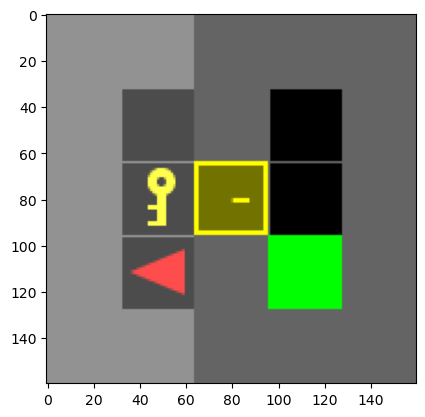

In [29]:
size = 5
seed = 42

env = get_door_key_env(size)

  0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1 [00:00<?, ?it/s]

Step:   0%|          | 0/1000 [00:00<?, ?it/s]

Start! Agent: PPO.


  0%|          | 0/3000000 [00:00<?, ?it/s]

/var/folders/n5/sdw3gh1d1lj552x1k2x500mw0000gn/T/ipykernel_17809/2068944089.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs).float() # convert to float tensor


Start! Agent: RRR.


  0%|          | 0/3000000 [00:00<?, ?it/s]

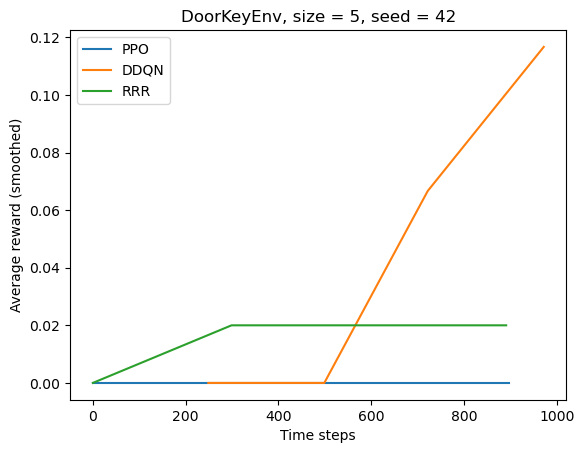

In [33]:
max_frames = 1000
max_episodes = 3000000
nonstop = True

config = get_default_config()
agent = DQNAgent(env=env, **config)

dqn_logs = dqn_sweep([agent], ['DDQN'], max_steps=max_frames)
for label, df in dqn_logs.groupby('Agent'):
    pass

num_frames_DDQN = df['steps'].to_list()
rewards_DDQN = df['return'].to_list()
# first prepend 4 zeros to the rewards to make the plot start at 0
rewards_DDQN = [0] * 4 + rewards_DDQN
# smooth the rewards by averaging on 5 of them
rewards_DDQN = [sum(rewards_DDQN[i:i+5])/5 for i in range(len(rewards_DDQN)-4)]

agent_PPO = PPO(ACModel, env=env, args=Config(), seed=seed)
num_frames_1, smooth_rs_1 = agent_PPO.train(max_episodes, nonstop=nonstop, max_frames=max_frames)
agent_RRR_2 = RRR(ACModel, env=env, args=Config(bad_fit_threshold=0.77, importance_sampling_clip=2.0), seed=seed)
num_frames_2, smooth_rs_2, fits_2 = agent_RRR_2.train(max_episodes, nonstop=nonstop, max_frames=max_frames)

plt.plot(num_frames_1, smooth_rs_1, label='PPO')
plt.plot(num_frames_DDQN, rewards_DDQN, label='DDQN')
plt.plot(num_frames_2, smooth_rs_2, label='RRR')
plt.xlabel('Time steps')
plt.ylabel('Average reward (smoothed)')
plt.title(f'DoorKeyEnv, size = {size}, seed = {seed}')
plt.legend()
plt.show()


Start! Agent: PPO.


  0%|          | 0/3000000 [00:00<?, ?it/s]

/var/folders/n5/sdw3gh1d1lj552x1k2x500mw0000gn/T/ipykernel_17809/2068944089.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs).float() # convert to float tensor


Start! Agent: RRR.


  0%|          | 0/3000000 [00:00<?, ?it/s]

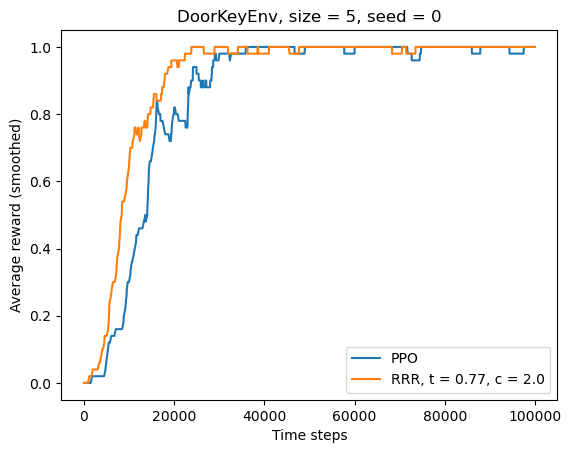

In [23]:
seed = 0
max_episodes = 3000000

agent_PPO = PPO(ACModel, env=env, args=Config(), seed=seed)
num_frames_1, smooth_rs_1 = agent_PPO.train(max_episodes, nonstop=True, max_frames=100000)
agent_RRR_2 = RRR(ACModel, env=env, args=Config(bad_fit_threshold=0.77, importance_sampling_clip=2.0), seed=seed)
num_frames_2, smooth_rs_2, fits_2 = agent_RRR_2.train(max_episodes, nonstop=True, max_frames=100000)

plt.plot(num_frames_1, smooth_rs_1, label='PPO')
plt.plot(num_frames_2, smooth_rs_2, label='RRR, t = 0.77, c = 2.0')
plt.xlabel('Time steps')
plt.ylabel('Average reward (smoothed)')
plt.title(f'DoorKeyEnv, size = {size}, seed = {seed}')
plt.legend()
plt.show()

In [139]:
fits_2

[1.0,
 0.8679245114326477,
 0.8301886916160583,
 0.8820754885673523,
 0.9433962106704712,
 0.8726415038108826,
 0.7641509175300598,
 0.75,
 0.7971698045730591,
 0.7735849022865295,
 0.7547169923782349,
 0.7264150977134705,
 0.7264150977134705,
 0.7311320900917053,
 0.8207547068595886,
 0.7783018946647644,
 0.7547169923782349,
 0.7547169923782349,
 0.7877358198165894,
 0.7877358198165894,
 0.7735849022865295,
 0.7311320900917053,
 0.7594339847564697,
 0.8066037893295288,
 0.7122641801834106,
 0.7547169923782349,
 0.8254716992378235,
 0.7641509175300598,
 0.75,
 0.8066037893295288,
 0.7547169923782349,
 0.7971698045730591,
 0.8113207817077637,
 0.7783018946647644,
 0.7641509175300598,
 0.7594339847564697,
 0.7547169923782349,
 0.7877358198165894,
 0.75,
 0.7122641801834106,
 0.7216981053352356,
 0.7783018946647644,
 0.7688679099082947,
 0.7594339847564697,
 0.7830188870429993,
 0.7735849022865295,
 0.8113207817077637,
 0.7547169923782349,
 0.7452830076217651,
 0.8066037893295288,
 0.75,
